# Step 1

* Load scalar, waveform and image h5 files
* Snap points onto a grid in x1-x2 space.
* Interpolate onto regular y1 grid.
* Generate file "rawgrid_..." containing the 5D density array in slit-screen (x1-x2-y1-x3-y3) coordinates.
* Generate file "slit_coordinates_..." containing the coordinates along each dimension in "rawgrid...".

In [2]:
import sys
import os
from os.path import join
import time
from datetime import datetime
import importlib
import numpy as np
import pandas as pd
import h5py
import imageio
from scipy import ndimage
from scipy import interpolate
import skimage
from tqdm import tqdm
from tqdm import trange
from matplotlib import pyplot as plt
import proplot as pplt

sys.path.append('../..')
from tools import energyVS06 as energy
from tools import image_processing as ip
from tools import plotting as mplt
from tools import utils

In [3]:
pplt.rc['grid'] = False
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'viridis'

## Setup 

Global variables

In [4]:
N_PTS_Y = 33  # Number of points in y grid (sweeping slit).
ny, nx = np.loadtxt('processed_image_shape.txt').astype('int')
print(f'Processed image shape = ({ny}, {nx})')

Processed image shape = (147, 194)


In [5]:
datadir = '/Diagnostics/Data/Measurements/scan-xxpy-image-ypdE/2022-04-29/'
filenames = os.listdir(datadir)
filenames

['220429190854-scan-xxpy-image-ypdE.png',
 '220429190854-scan-xxpy-image-ypdE.csv',
 '220429190854-scan-xxpy-image-ypdE.html',
 '220429190854-scan-xxpy-image-ypdE.txt',
 '220429190854-scan-xxpy-image-ypdE.h5',
 'preproc-220429190854-scan-xxpy-image-ypdE.h5',
 'images.h5']

In [6]:
filename = '220429190854-scan-xxpy-image-ypdE'
file = h5py.File(join(datadir, 'preproc-' + filename + '.h5'), 'r')
data_sc = file['/scalardata']
data_wf = file['/wfdata']
data_im = file['/imagedata']

print('All attributes:')
print()
for data in [data_sc, data_wf, data_im]:
    print(data.name)
    for item in data.dtype.fields.items():
        print(item)
    print()

All attributes:

/scalardata
('x_PositionSync', (dtype('<f8'), 0))
('xp_PositionSync', (dtype('<f8'), 8))
('y_PositionSync', (dtype('<f8'), 16))
('bcm04', (dtype('<f8'), 24))
('cam34_Integral', (dtype('<f8'), 32))
('cam34_Saturation', (dtype('<f8'), 40))
('iteration', (dtype('int64'), 48))
('timestamp', (dtype('<f8'), 56))

/wfdata
('cam34_ProfileX', (dtype(('<f4', (612,))), 0))
('cam34_ProfileY', (dtype(('<f4', (512,))), 2448))

/imagedata
('cam34_Image', (dtype(('<f8', (28518,))), 0))



In [7]:
cam = 'cam34'
sdiag = ['bcm04', f'{cam}_Integral', f'{cam}_Saturation']
acts = ['y_PositionSync', 'xp_PositionSync', 'x_PositionSync']
print('Scalar diagnostics:', sdiag)
print('Actuators:', acts)

Scalar diagnostics: ['bcm04', 'cam34_Integral', 'cam34_Saturation']
Actuators: ['y_PositionSync', 'xp_PositionSync', 'x_PositionSync']


In [8]:
signal = np.copy(data_sc[:, cam + '_Integral'])
ipeak = np.argmax(signal)
print('Index of peak signal:', ipeak)

Index of peak signal: 31474


### Slit correlations

In [14]:
corr = np.identity(len(acts))
intercept = np.zeros(corr.shape)
for i, act1 in enumerate(acts):
    for j, act2 in enumerate(acts):
        fit1d = np.polyfit(data_sc[:, act1], data_sc[:, act2], 1, w=signal)
        print(f'{act2} vs. {act1}: slope = {fit1d[0]:.3f}')
        corr[i, j] = fit1d[0]
        intercept[i, j] = fit1d[1]
print('Correlation matrix:')
print(corr)

y_PositionSync vs. y_PositionSync: slope = 1.000
xp_PositionSync vs. y_PositionSync: slope = -0.035
x_PositionSync vs. y_PositionSync: slope = -0.009
y_PositionSync vs. xp_PositionSync: slope = -0.006
xp_PositionSync vs. xp_PositionSync: slope = 1.000
x_PositionSync vs. xp_PositionSync: slope = 0.375
y_PositionSync vs. x_PositionSync: slope = -0.007
xp_PositionSync vs. x_PositionSync: slope = 1.844
x_PositionSync vs. x_PositionSync: slope = 1.000
Correlation matrix:
[[ 1.         -0.03543776 -0.00908033]
 [-0.00580201  1.          0.37532466]
 [-0.00730315  1.84375654  1.        ]]


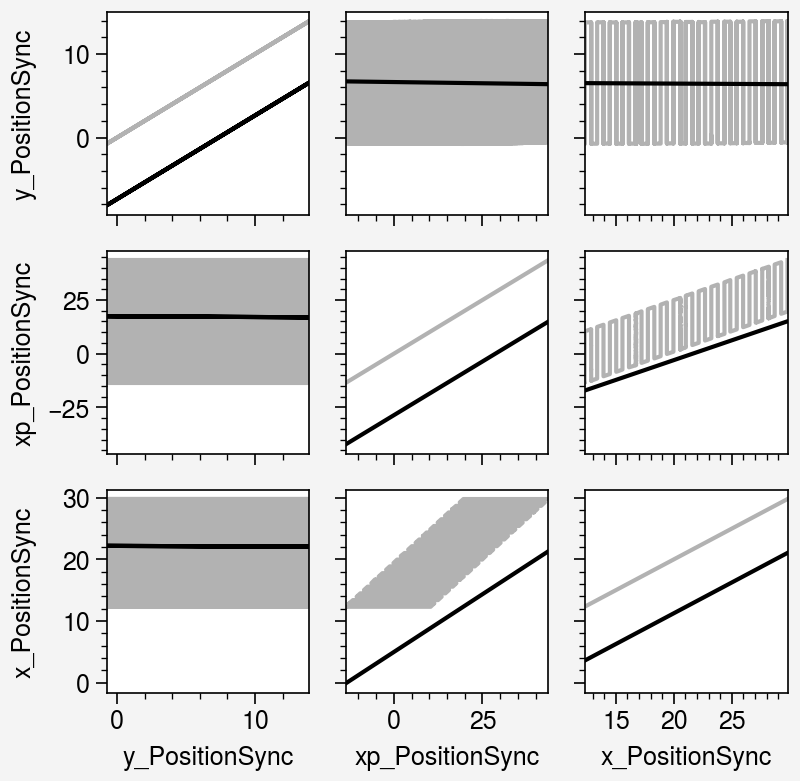

In [15]:
fig, axes = pplt.subplots(nrows=3, ncols=3, figwidth=4.0, 
                          spanx=False, spany=False, aligny=True)
for i in range(3):
    for j in range(3):
        ax = axes[i, j]
        x = data_sc[acts[j]]
        y = data_sc[acts[i]]
        ax.plot(x, y, color='black', alpha=0.3)
        xmin, xmax = np.min(x), np.max(x)
        _x = x - 0.5 * (xmax - xmin)
        _y = corr[j, i] * _x + intercept[j, i]
        ax.plot(x, _y, color='black')
for i, act in enumerate(acts):
    axes[-1, i].set_xlabel(act)
    axes[i, 0].set_ylabel(act)
plt.show()

Work in the "normalized" (decorrelated) slit-screen coordinates. First, try transforming back to square grid.

In [16]:
# Shearing matrix 
ndim = 3
M = np.identity(ndim)
M[1, 2] = 1.9  # dxp / dx
Minv = np.linalg.inv(M)

# Center slit positions
d1_center = 6.5  # y
d2_center = 15.0  # xp
d3_center = 21.0  # x

center = np.array([d1_center, d2_center, d3_center])

Test on CSV file (planned points).

In [17]:
# Find out how many rows to skip. 
csv_filename = join(datadir, filename + '.csv')
skiprows = 0
for line in open(csv_filename, 'r'):
    if line.startswith('#'):
        skiprows += 1
print('skiprows =', skiprows)

# Read the CSV file.
names = []
for i in range(1, ndim + 1):
    names.extend([f'start{i}', f'stop{i}', f'step{i}'])
df = pd.read_table(csv_filename, skiprows=skiprows, sep='\s+', header=None, names=names)
df

skiprows = 23


,start1,stop1,step1,start2,stop2,step2,start3,stop3,step3
0,-0.75,13.75,2.266,-13.625,-13.625,0.0,12.25,12.25,0.0
1,13.75,-0.75,2.266,-12.875,-12.875,0.0,12.25,12.25,0.0
2,-0.75,13.75,2.266,-12.125,-12.125,0.0,12.25,12.25,0.0
3,13.75,-0.75,2.266,-11.375,-11.375,0.0,12.25,12.25,0.0
4,-0.75,13.75,2.266,-10.625,-10.625,0.0,12.25,12.25,0.0
...,...,...,...,...,...,...,...,...,...
1084,-0.75,13.75,2.266,40.625,40.625,0.0,29.75,29.75,0.0
1085,13.75,-0.75,2.266,41.375,41.375,0.0,29.75,29.75,0.0
1086,-0.75,13.75,2.266,42.125,42.125,0.0,29.75,29.75,0.0
1087,13.75,-0.75,2.266,42.875,42.875,0.0,29.75,29.75,0.0


Make sure the actuator names in this notebook match the order in the CSV file.

In [18]:
header_line = None
for row, line in enumerate(open(join(datadir, filename + '.csv'), 'r')):
    if row == skiprows - 1:
        header_line = line
        break
for char in ['#', ',']:
    header_line = header_line.replace(char, '')
header_line = header_line.lstrip()
print(header_line.split())

['step', 'ITSF_Diag:Slit_HZ34a', 'start', 'stop', 'speed', 'ITSF_Diag:Slit_VT34b', 'start', 'stop', 'speed', 'ITSF_Diag:Slit_VT34a', 'start', 'stop', 'speed']


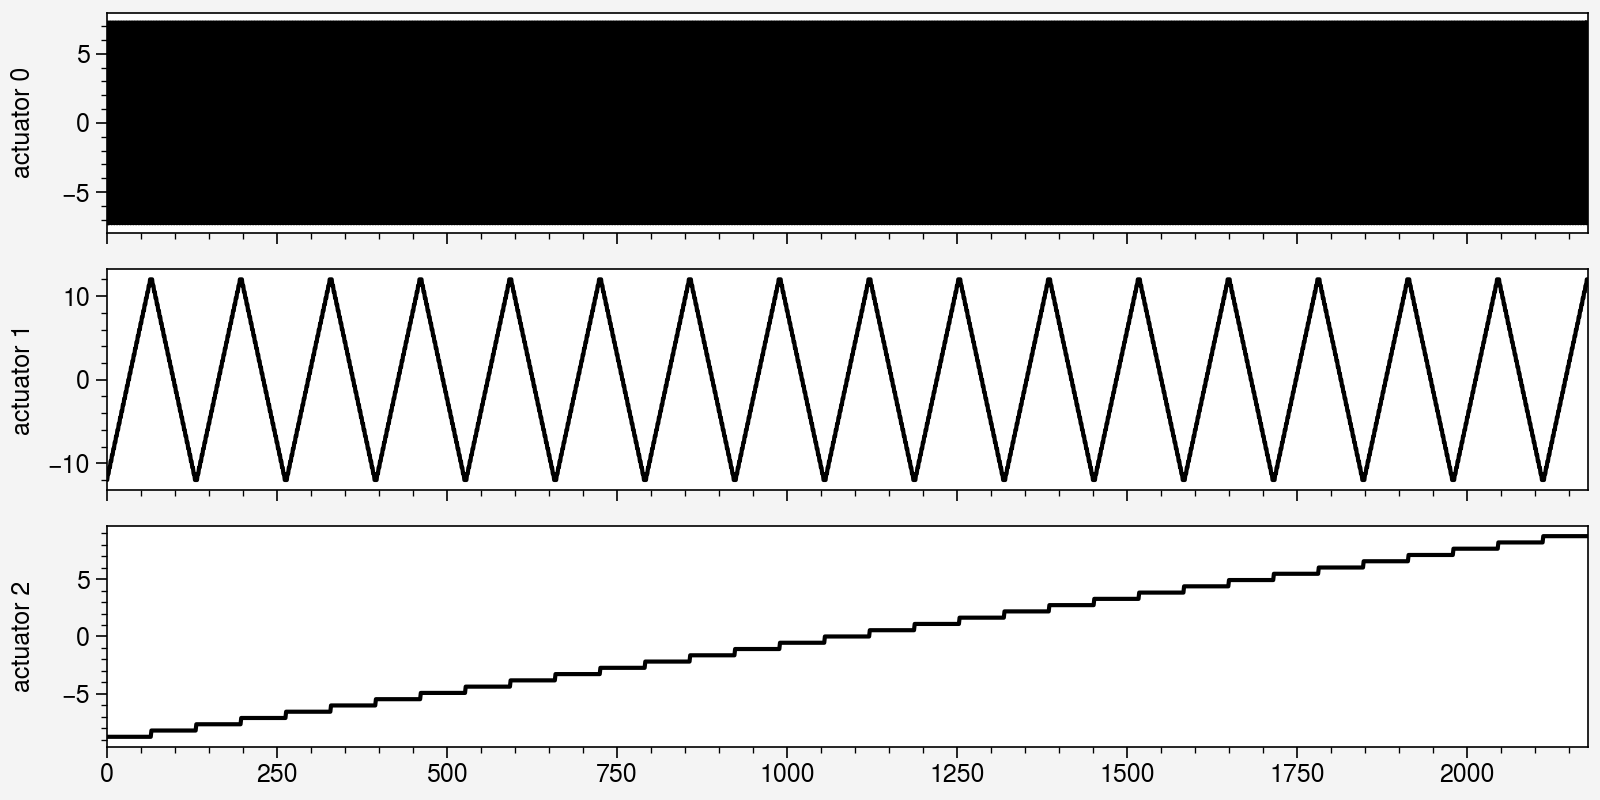

In [19]:
# Extract actuator points.
act_pts = [df.loc[:, [f'start{i}', f'stop{i}']].values.ravel() for i in range(1, ndim + 1)]
act_pts = np.array(act_pts).T

# Undo linear transformation.
act_pts_n = np.apply_along_axis(lambda pt: np.matmul(Minv, pt - center), 1, act_pts)

# Plot actuator points in "normalized" space.
fig, axes = pplt.subplots(nrows=3, figsize=(8.0, 4.0), spany=False, aligny=True)
for i, ax in enumerate(axes):
    ax.plot(act_pts_n[:, i], color='black', lw=None, marker='.', ms=0)
    ax.format(ylabel=f'actuator {i}')

Create dataframe of planned actuator points in real and normalized space.

In [20]:
dim_names = ['y1', 'x2', 'x1']
columns = []
for i, dim_name in enumerate(dim_names):
    columns.extend([dim_name, dim_name + '_n'])
df = pd.DataFrame(index=df.index, columns=columns)
for i, dim_name in enumerate(dim_names):
    df[dim_name] = act_pts[::2, i]
    df[dim_name + '_n'] = act_pts_n[::2, i]
df

,y1,y1_n,x2,x2_n,x1,x1_n
0,-0.75,-7.25,-13.625,-12.00,12.25,-8.75
1,13.75,7.25,-12.875,-11.25,12.25,-8.75
2,-0.75,-7.25,-12.125,-10.50,12.25,-8.75
3,13.75,7.25,-11.375,-9.75,12.25,-8.75
4,-0.75,-7.25,-10.625,-9.00,12.25,-8.75
...,...,...,...,...,...,...
1084,-0.75,-7.25,40.625,9.00,29.75,8.75
1085,13.75,7.25,41.375,9.75,29.75,8.75
1086,-0.75,-7.25,42.125,10.50,29.75,8.75
1087,13.75,7.25,42.875,11.25,29.75,8.75


## Interpolation 

### Snap onto x1-x2 grid

In [41]:
importlib.reload(utils)

<module 'tools.utils' from '/home/46h/btf-data-analysis/scan3d/scan-xxpy-image-ypdE/../../tools/utils.py'>

In [42]:
GV, BI = [], []
for i, dim_name in enumerate(dim_names):
    gv, idx = utils.snap(act_pts_n[:, i], n=11*15)
    GV.append(gv)
    BI.append(idx)
    print(f'{dim_name}: {len(gv)} grid points')

y1: 2 grid points
x2: 33 grid points
x1: 33 grid points


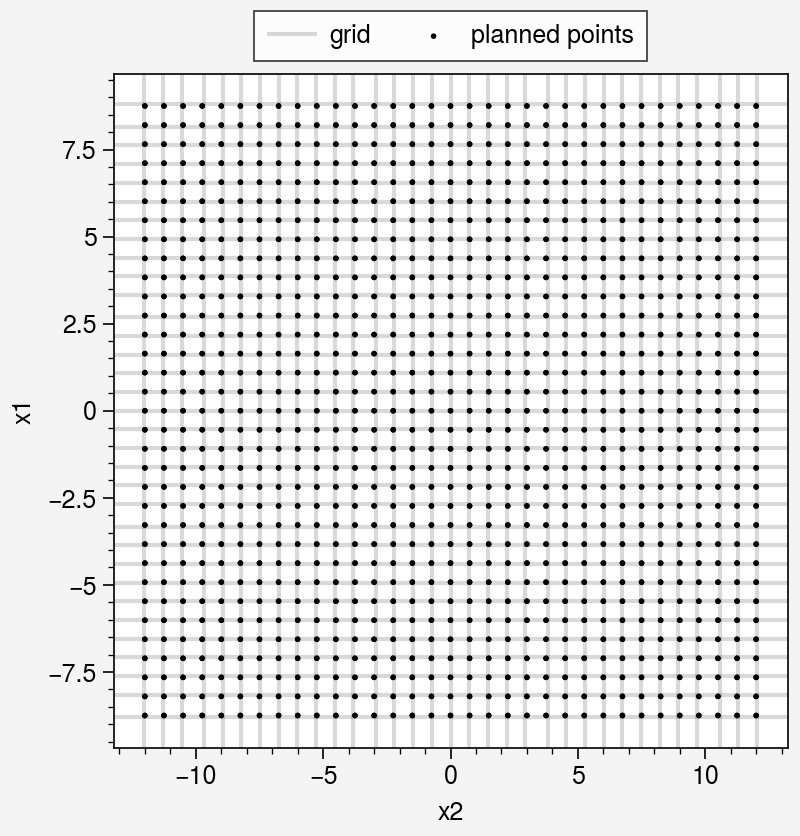

In [44]:
GV_X2_n, GV_X1_n = np.meshgrid(GV[1], GV[2], indexing='ij')

fig, ax = pplt.subplots(figwidth=4.0)
kws = dict(color='black', alpha=0.15)
for gv in GV[1]:
    ax.axvline(gv, **kws)
for gv in GV[2]:
    h1 = ax.axhline(gv, **kws)
h2 = ax.scatter(act_pts_n[:, 1], act_pts_n[:, 2], c='black', s=4, ec='None') 
ax.legend([h1, h2], labels=['grid', 'planned points'], loc='t')
ax.format(xlabel=dim_names[1], ylabel=dim_names[2])
plt.show()

`POINTS2D` holds the iteration number on the x2-x1 grid. (The number of iterations is half the number of sweeps.)

In [53]:
POINTS2D = np.zeros((len(GV[2]), len(GV[1])))
POINTS2D[:] = np.nan
steps = []
iteration = 0
for i in range(POINTS2D.shape[0]):
    for j in range(POINTS2D.shape[1]):
        idx, = np.where((BI[2] == i) & (BI[1] == j))
        if len(idx) > 0:
            steps.append(idx)
            POINTS2D[i, j] = iteration
        else:
            print(f'Bin {i},{j} is empty')
        iteration += 1
POINTS2D = POINTS2D.astype(int)

What is going on below?

In [54]:
data_iteration = data_sc[:, 'iteration'].copy()
idx_bin = []
for i, step in enumerate(steps):
    indices = np.unique((step / 2 + 1).astype(int))
    idx = np.hstack([np.where(data_iteration == j)[0] for j in indices])
    idx_bin.append(np.unique(idx))

### Observe one sweep

We will observe the sweep containing the largest camera integral in the scan.

In [67]:
iteration_peak, n_iterations = None, len(steps)
for iteration in range(n_iterations):
    if ipeak in idx_bin[iteration]:
        iteration_peak = iteration
        
iteration = iteration_peak
idx = idx_bin[iteration]
print(f'Peak is in iteration {iteration}')
print(f'Set iteration = {iteration}')
print(f'Set idx = idx_bin[iteration] = {idx}')

Peak is in iteration 742
Set iteration = 742
Set idx = idx_bin[iteration] = [31454 31455 31456 31457 31458 31459 31460 31461 31462 31463 31464 31465
 31466 31467 31468 31469 31470 31471 31472 31473 31474 31475 31476 31477
 31478 31479 31480 31481 31482 31483 31484 31485 31486 31487 31488 31489
 31490 31491 31492 31493 31494 31495 31496]


Observe the actuator positions and camera integral during the sweep.

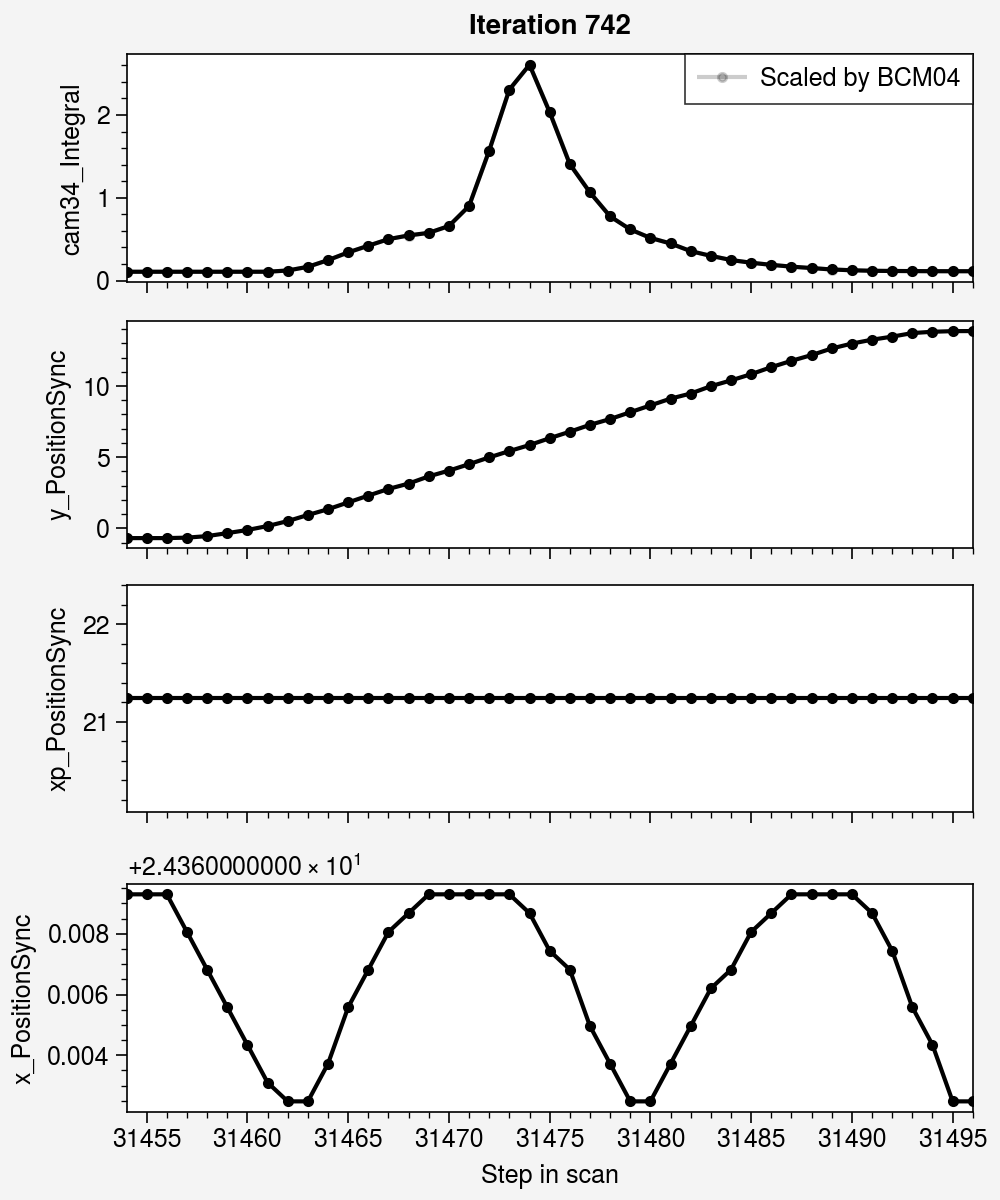

In [66]:
bcm_mean = np.mean(data_sc[:, 'bcm04'])
bcm_scale = bcm_mean / data_sc[idx, 'bcm04']

kws = dict(marker='.', color='black')
fig, axes = pplt.subplots(nrows=4, figsize=(5, 6), spany=False, aligny=True)
for _scale, alpha, label in zip([1.0, bcm_scale], [1.0, 0.2], [None, 'Scaled by BCM04']):
    axes[0].plot(
        idx,
        data_sc[idx, cam + '_Integral'] * _scale,
        alpha=alpha,
        label=label,
        **kws,
    )
axes[0].legend(loc='upper right')
axes[0].format(ylabel=f'{cam}_Integral')
for ax, act in zip(axes[1:], acts):
    ax.plot(
        idx,
        data_sc[idx, act],
        **kws,
    )
    ax.format(ylabel=act)
axes.format(xlabel='Step in scan', suptitle=f'Iteration {iteration}')
plt.show()

Observe the image on the screen during the sweep. 

In [69]:
def get_image(i):
    return data_im[i, cam + '_Image'].reshape(ny, nx)

In [74]:
ipeak_sweep = np.argmax(data_sc[idx, cam + '_Integral'])
norm_pixel_value = np.max(data_im[idx[ipeak_sweep], cam + '_Image'])
cmap = pplt.Colormap('dusk_r')
greyscale = False

_ims = []
for i in tqdm(idx):
    _im = get_image(i) / norm_pixel_value
    if not greyscale:
        _im = cmap(_im)
    _ims.append(np.uint8(_im * np.iinfo(np.uint8).max))

gif_filename = f'_output/iteration{iteration}.gif'
imageio.mimwrite(gif_filename, _ims, fps=6)

100%|██████████| 43/43 [00:00<00:00, 1105.81it/s]


![](_output/iteration742.gif)

### Smooth and interpolate along y_PositionSync 

We have snapped all points onto an x1-x2 grid. We now interpolate the y1 coordinate — the sweeping variable.

In [89]:
# Make a 3d image.
im3d = np.array([get_image(i) for i in idx])

# Apply a smoothing filter along the first dimension (y_PositionSync). 
im3d_smooth = ndimage.median_filter(im3d, size=(3, 1, 1), mode='constant', cval=0.0) 

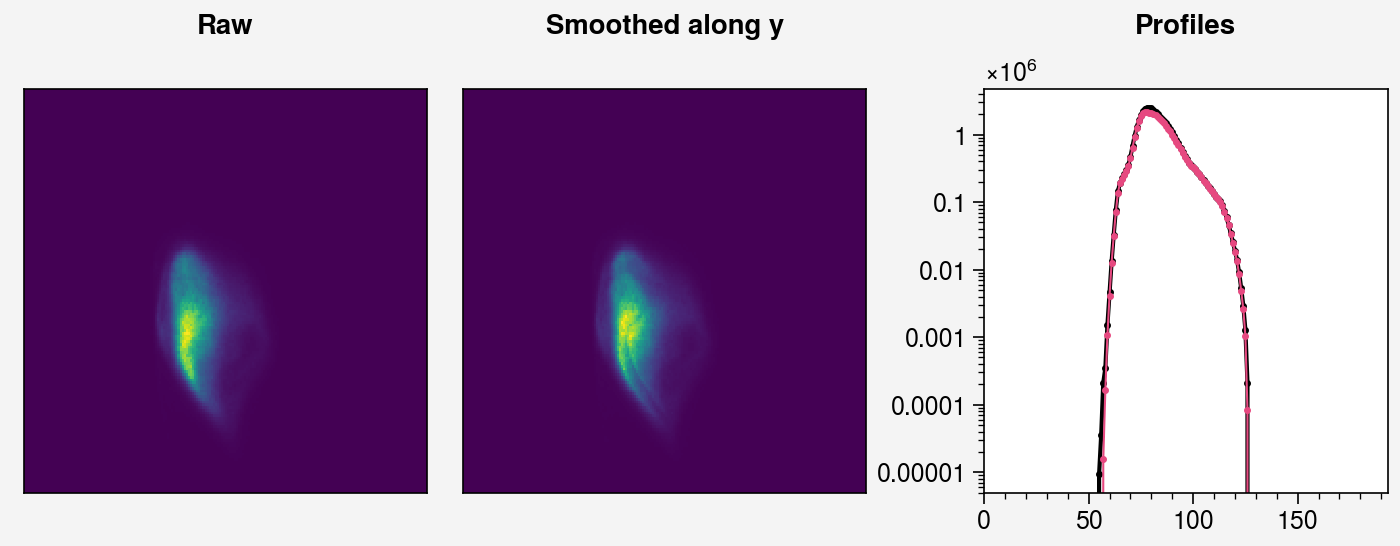

In [90]:
i, _, _ = np.unravel_index(np.argmax(im3d), im3d.shape)

fig, axes = pplt.subplots(ncols=3, figwidth=7, sharey=False)
axes[0].pcolormesh(im3d[i, :, :])
axes[1].pcolormesh(im3d_smooth[i, :, :])
axes[2].plot(np.sum(im3d[i, :, :], axis=0), color='black', marker='.', ms=3)
axes[2].plot(np.sum(im3d_smooth[i, :, :], axis=0), color='pink6', marker='.', ms=3, lw=0.75)
axes.format(toplabels=['Raw', 'Smoothed along y', 'Profiles'])
axes[:-1].format(xticks=[], yticks=[])
axes[-1].format(yscale='log')
plt.show()

### Interpolate to y grid

In [ ]:
# Get the y slit position at each frame.
yvals = data_sc[:, 'y_PositionSync'][idx]

# Deal with backwards-moving slit.
idx_sort = np.argsort(yvals)
yvals = yvals[idx_sort]
im3d = im3d[idx_sort, :, :]
im3d_smooth = im3d_smooth[idx_sort, :, :]

# Deal with repeating points (otherwise interpolation will not work).
yvals = utils.avoid_repeats(yvals, pad=1e-7)
    
# Interpolate.
ygrid = np.linspace(np.min(yvals), np.max(yvals), N_PTS_Y)  
ypix = np.arange(ny) 
xpix = np.arange(nx) 
newpoints = utils.get_grid_coords(ygrid, ypix, xpix, indexing='ij')
arr3d = interpolate.interpn(
    (yvals, ypix, xpix), 
    im3d_smooth, 
    newpoints, 
    method='linear', 
    bounds_error=False, 
    fill_value=0.0
)
arr3d = arr3d.reshape(N_PTS_Y, ny, nx)

In [ ]:
row, col = utils.max_indices(get_image(ipeak))

fig, axes = pplt.subplots(ncols=2, sharey=False)
for i, ax in enumerate(axes):
    for lw, c, x, arr, label in zip(
        [None, None, 0], 
        [None, None, 'black'], 
        [yvals, ygrid, yvals], 
        [im3d_smooth, arr3d, im3d],
        ['smoothed', 'interpolated', 'raw'],
    ):
        if i == 0:
            y = utils.project(arr, 0)
        else:
            y = arr[:, row, col]
        ax.plot(x, y, lw=lw, color=c, label=label, marker='.')
axes.format(
    yscale='log', 
    xlabel='y [mm]'
)
axes[1].legend(loc='upper right', ncol=1,)
axes[0].format(title=f'Sum over image')
axes[1].format(title=f'Pixel ({row}, {col})')
plt.show()

Find the frame with the maximum pixel.

In [ ]:
max1 = np.unravel_index(np.argmax(im3d), im3d.shape)[0]
max2 = 1 + np.unravel_index(np.argmax(arr3d), arr3d.shape)[0]  # why + 1?
row1, col1 = utils.max_indices(im3d[max1, :, :])
row2, col2 = utils.max_indices(arr3d[max2, :, :])
print(f'max1, row1, col1 = ({max1}, {row1}, {col1})')
print(f'max2, row2, col2 = ({max2}, {row2}, {col2})')

In [ ]:
im1, im2 = im3d[max1], arr3d[max2]
fig, axes = pplt.subplots(ncols=2, nrows=2, figwidth=None, sharex=False, sharey=False)
for col, _im in enumerate([im1, im2]):
    for row, norm in enumerate([None, 'log']):
        mplt.plot_image(_im.T, ax=axes[row, col], norm=norm, colorbar=True)
axes.format(leftlabels=['Normal scale', 'Log scale'],
            toplabels=['Raw image', 'Interpolated along y'])

In [ ]:
fig, axes = pplt.subplots(ncols=2, sharey=False, spanx=False, figsize=(8, 2))
axes[0].plot(np.sum(arr3d[max2, :, :], axis=0), color='black', alpha=0.2, label='interpolated')
axes[0].plot(np.sum(im3d[max1, :, :], axis=0), marker='.', ms=2, lw=0, color='black', label='raw')
axes[0].legend(ncol=1)
axes[0].format(yscale='log', title='ProfileX')
axes[1].plot(arr3d[-2, :, :].ravel(), marker='.', lw=0, color='black', ms=1, label='Raw')
axes[1].plot(arr3d[-2, :, :].ravel(), color='black', alpha=0.2, label='Interpolated')
axes[1].legend(loc='upper left', ncols=1)
axes[1].format(title='Pixels in edge frame', xlabel='Pixel number')

In [ ]:
fig, axes = pplt.subplots(ncols=3, sharey=False, sharex=False)
axes[0].pcolormesh(im3d[max1, :, :])
kws = dict(color='white', lw=0.785, alpha=0.5)
axes[0].axvline(col1, **kws)
axes[0].axhline(row1, **kws)
kws = dict(marker='.', color='black')
for im, row, col, label in zip([arr3d[max2], im3d[max1]], [row2, row1], [col2, col1], ['Interpolated', 'Raw']):
    if label == 'Raw':
        kws['alpha'] = 0.2
        kws['lw'] = None
        kws['ms'] = 3.0
    elif label == 'Interpolated':
        kws['alpha'] = 1.0
        kws['lw'] = None
        kws['ms'] = 3.0
    axes[1].plot(im[row, :] / np.sum(im[row, :]), label=label, **kws)
    axes[2].plot(im[:, col] / np.sum(im[:, col]), label=label, **kws)
axes[2].legend(ncols=1)
axes[1].set_title('Slice in Cam06 X')
axes[2].set_title('Slice in Cam06 Y')
axes[1:].format(yscale='log')
plt.show()

## Save slit coordinates

In [ ]:
# ordering: y, xp, x
x2_x1_n = np.vstack([GV_X2_n.ravel(), GV_X1_n.ravel()]).T
x2_x1 = utils.apply(M[1:, 1:], x2_x1_n) + center[1:]
GV_X2 = x2_x1[:, 0].reshape(GV_X2_n.shape)
GV_X1 = x2_x1[:, 1].reshape(GV_X1_n.shape)

fig, axes = pplt.subplots(ncols=2, figwidth=8, sharey=False, sharex=False)
for ax, (grid1, grid2), pts in zip(axes, [(GV_X2, GV_X1), (GV_X2_n, GV_X1_n)], [act_pts, act_pts_n]):
    ax.plot(grid1[:], grid2[:], color='black', alpha=0.2, lw=3)
    ax.plot(pts[:, 1], pts[:, 2], color='black', marker='.', ms=2, lw=0.5)
axes.format(xlabel='x2', ylabel='x1')
axes[1].format(title='"Normalized"')

Define y grid.

In [ ]:
y1 = data_sc[:, 'y_PositionSync']
ygrid = np.linspace(np.min(y1), np.max(y1), N_PTS_Y)

Obtain coordinates on the 3D grid.

In [ ]:
X1 = np.repeat(GV_X1[:, :, np.newaxis], N_PTS_Y, axis=2)
X2 = np.repeat(GV_X2[:, :, np.newaxis], N_PTS_Y, axis=2)
Y1 = np.zeros(X1.shape)
for i in range(len(GV[2])):
    for j in range(len(GV[1])):
        Y1[i, j, :] = ygrid

In [ ]:
fig, axes = pplt.subplots(nrows=3, figsize=(5, 4), spany=False, aligny=True)
for ax, G, ylabel in zip(axes, [X1, X2, Y1], ["x1 [mm]", "x2 [mm]", "y1 [mm]"]):
    ax.plot(G.ravel(), color='black')
    ax.format(ylabel=ylabel)
axes.format(xlabel='Step')

In [ ]:
fig, ax = pplt.subplots()
ax.plot(X2.ravel(), X1.ravel(), color='black', marker='.', ms=1, lw=0.5)
ax.format(xlabel='x2 [mm]', ylabel='x1 [mm]')

In [ ]:
coord_3d = np.stack([X1, X2, Y1], axis=0)
print(f'coord_3d.shape = {coord_3d.shape}')

In [ ]:
savefilename = f'slit_coordinates_{filename}.npy'
np.save(savefilename, coord_3d)

## View projections and slices of data points in one iteration (sweep). 
coordinates y1, y3, x3

In [ ]:
smooth = True
a3d = ip.get_image_3d(
    data_im[idx, cam + '_Image'], 
    data_sc[idx, 'y_PositionSync'], 
    ygrid, ny, nx, smooth=smooth
)

In [ ]:
fig, ax = pplt.subplots()
ax.plot(ygrid, utils.project(a3d, 0), marker='.', color='black')
ax.format(xlabel='y1 [mm]', title='Interpolated signal dependence on y slit')

In [ ]:
plot_kws = dict(discrete=False, colorbar=True)
fig, axes = pplt.subplots(nrows=2, ncols=2, sharex=False, sharey=False)
x3 = int(nx * 1 / 2) 
axes[0].pcolormesh(a3d[:, :, x3], **plot_kws)
axes[0].format(xlabel='y3', ylabel='y1', title=f'x3 = {x3}')
axes[1].pcolormesh(a3d.sum(axis=2), **plot_kws)
axes[1].format(xlabel='y3', ylabel='y1', title='Projection onto y1-y3')
axes[2].pcolormesh(a3d.sum(axis=0), **plot_kws)
axes[2].format(xlabel='x3', ylabel='y3', title='Projection onto x3-y3')
axes[3].axis('off')
plt.show()

## Save 5D array as memory map 

In [ ]:
shape = [len(GV[2]), len(GV[1])] + list(a3d.shape)  # [x1, x2, y1, y3, x3]
shape = tuple(shape)
np.savetxt('rawgrid_shape.txt', shape)
print('shape:', shape)

In [ ]:
im_dtype = get_image(0).dtype
file = open('im_dtype.txt', 'w')
file.write(str(im_dtype))
file.close()
print('image dtype:', im_dtype)

In [ ]:
savefilename = f'rawgrid_{filename}.mmp'
arrays_3d = np.memmap(savefilename, shape=shape, dtype=im_dtype, mode='w+') 
for i in trange(POINTS2D.shape[0]):
    for j in range(POINTS2D.shape[1]):
        try:
            iteration = POINTS2D[i, j]
            idx = idx_bin[iteration]
            arrays_3d[i, j, :, :, :] = ip.get_image_3d(
                data_im[idx, cam + '_Image'], 
                data_sc[idx, 'y_PositionSync'], 
                ygrid, ny, nx, smooth=False,
            )
        except IndexError:
            print(f'No points in grid bin ({i}, {j})')
            arrays_3d[i, j, :, :, :] = 0
del arrays_3d